# RUL Prediction with LSTM
a. Xs' only
b. Xs' and $\theta$

1. Load flight effects model and validate performance
2. set up hyperparameter tuning for RUL prediction network (LSTM)
3. Evaluate different lookback windows or implement adaptive window

In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
#import tensorflow_addons as tfa

import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/macslab/phm2021_data_challenge
2.8.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 0. Connect to db and load the data

In [2]:
# THESE ARE YOUR CREDENTIALS IN PLAIN TEXT!
params = {'datasource.username': 'macslab', # the username of the logged in user
            'datasource.password': 'Ch0colate!', 
            'datasource.database': 'ncmapss_db', # <- NO CHANGE 
            'datasource.url': 'localhost', # <- or your database installation location
            'datasource.port': '5432'} # <- most likely don't change
#print(params)
db, cur =  api.connect(params)
db.set_session(autocommit=True)
del(params)

[INFO] connecting to db.
[INFO] connected.


In [3]:
units = api._get_units(db=db)
units.head()

,id,serial_number,age,eol,rul,group_id,Fc,unit,dataset
0,1,xhJzs6e3,0.0,100.0,100.0,1,1,1,DS01-005
1,2,a2wH8lJP,0.0,75.0,75.0,1,3,2,DS01-005
2,3,zwaWwxPl,0.0,100.0,100.0,1,2,3,DS01-005
3,4,ByMDLFeB,0.0,95.0,95.0,1,1,4,DS01-005
4,5,rcedq8Jy,0.0,89.0,89.0,1,3,5,DS01-005


In [ ]:
# import Queue
# from threading import Thread

# units = api._get_units(db=db)
# tables = ['summary_tb', 'telemetry_tb']

# def func(units, tables, downsample):
#     return str(units) + str(tables) + str(downsample)
# def delegate():
#     return func('units', ' tables', 20)
# units = api._get_units(db=db)
# data_frames = []
# for i in range(int(len(units)/10)):
    
    
    # df = api._get_data(db=db,
    #                    units=units,
    #                    tables=tables,
    #                    downsample=20).astype(np.float32)
    

In [4]:
tables = ['summary_tb', 'telemetry_tb']
downsample=20
df = api._get_data(db=db,
                   units=list(np.arange(1,40,1)),#pd.unique(units.id),
                   tables=tables,
                   downsample=downsample).astype(np.float32)
utils.add_time_column(units=list(np.arange(1,40,1)), df=df)
utils.add_rul_column(units=list(np.arange(1,40,1)), df=df)

## 1. Make Xs_prime and y 

In [5]:
X_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']## disregard comments #, 'Fc'] # will also have Fc_1, Fc_2, Fc_3
y_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
a_cols = ['cycle', 'hs', 'Fc', 'asset_id']

model = keras.models.load_model('models/ncmapss/flight_effects.h5')
yscaler = joblib.load('models/ncmapss/flight_effects_yscaler.pkl')
xscaler = joblib.load('models/ncmapss/flight_effects_xscaler.pkl')

Xs_prime = []
idx = np.random.randint(len(y_cols))
polys = []

for asset_id in pd.unique(df.asset_id):
    X_full = df[df.asset_id == asset_id][X_cols]
    pred = model.predict(xscaler.transform(X_full))
    Xs_prime.append(pred)
    
#    y_full = df[df.asset_id == asset_id][y_cols]
#    trace = yscaler.transform(y_full)
#     res = trace - pred

#     x = np.arange(0, len(res[:,0]))
#     x = x[0:len(x):10]
#     for i in range(0, len(y_cols)):
#         y = res[:,i]
#         y = y[0:len(y):10]
#         reg = np.poly1d(np.polyfit(x, y, 6))
#         polys.append(reg)

#     fig = plt.figure(figsize=(12,12))
#     filtered = np.zeros(res.shape)
#     x = np.arange(0, len(res[:,0]))
#     for j in range(len(y_cols)):
#         y = res[:,j]
#         p = polys[j]

#         diff = np.zeros((len(y),))
#         for i in range(len(y)):
#             predp = p(y[i])
#             diff[i] = y[i] - predp

#         mean = np.mean(diff)
#         std = np.std(diff)

#         filt = np.zeros((len(y),))
#         for i in range(len(res)):
#             if np.abs(np.abs(y[i]) - np.abs(p(x[i]))) > np.abs(mean)+3*std:
#                 filt[i] = p(x[i])
#             else:
#                 filt[i] = y[i]

#         filtered[:,j] = filt
#         utils.plot_trace_samples(fig, y, filt, p, j)
#     plt.show()
#     Xs_prime.append(pred)

2022-02-13 20:31:03.445590: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 20:31:03.683529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10133 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-02-13 20:31:04.456412: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


### now we have Xs_prime and y

In [ ]:
# xsp = np.concatenate(tuple(Xs_prime), axis=0)
# dfx = pd.concat([df[a_cols], pd.DataFrame(data=xsp, columns=y_cols)], axis=1)
# y = df['rul'].values
# dfx['rul'] = y
# print(xsp.shape)
# print(y.shape)

In [11]:
df.time = df.time + df.cycle
max(df.time)

In [13]:
df.time = df.time - 1
print(max(df.time))
df.head()

100.0


,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T50,P15,P2,P21,P24,Ps30,P40,P50,time,rul
0,1.0,1.0,0.004745,0.514113,0.721024,0.973463,1.0,20.0,1.0,0.796901,...,0.870434,0.929755,0.971001,0.929852,0.900711,0.842958,0.844355,0.933867,0.000000,100.0
1,1.0,1.0,0.009491,0.527381,0.721024,0.975626,1.0,40.0,1.0,0.794344,...,0.867308,0.928855,0.970602,0.928954,0.900275,0.840855,0.842275,0.928214,0.004484,99.995516
2,1.0,1.0,0.015266,0.532706,0.726415,0.972121,1.0,60.0,1.0,0.792912,...,0.866223,0.923906,0.964109,0.924012,0.896592,0.838708,0.840102,0.921573,0.008969,99.991031
3,1.0,1.0,0.021198,0.533042,0.729111,0.965541,1.0,80.0,1.0,0.787838,...,0.863896,0.915428,0.954571,0.915546,0.888994,0.833095,0.834455,0.913492,0.013453,99.986547
4,1.0,1.0,0.026287,0.537858,0.730458,0.962540,1.0,100.0,1.0,0.783920,...,0.861433,0.910194,0.948949,0.910319,0.884390,0.829024,0.830374,0.906861,0.017937,99.982063


## 2. split sets and view feature distributions

In [9]:
df[X_cols] = xscaler.transform(df[X_cols])
df.head()

,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T50,P15,P2,P21,P24,Ps30,P40,P50,time,rul
0,1.0,1.0,0.004745,0.514113,0.721024,0.973463,1.0,20.0,1.0,0.796901,...,0.870434,0.929755,0.971001,0.929852,0.900711,0.842958,0.844355,0.933867,0.000000,100.0
1,1.0,1.0,0.009491,0.527381,0.721024,0.975626,1.0,40.0,1.0,0.794344,...,0.867308,0.928855,0.970602,0.928954,0.900275,0.840855,0.842275,0.928214,0.004484,99.995516
2,1.0,1.0,0.015266,0.532706,0.726415,0.972121,1.0,60.0,1.0,0.792912,...,0.866223,0.923906,0.964109,0.924012,0.896592,0.838708,0.840102,0.921573,0.008969,99.991031
3,1.0,1.0,0.021198,0.533042,0.729111,0.965541,1.0,80.0,1.0,0.787838,...,0.863896,0.915428,0.954571,0.915546,0.888994,0.833095,0.834455,0.913492,0.013453,99.986547
4,1.0,1.0,0.026287,0.537858,0.730458,0.962540,1.0,100.0,1.0,0.783920,...,0.861433,0.910194,0.948949,0.910319,0.884390,0.829024,0.830374,0.906861,0.017937,99.982063


In [6]:
df[y_cols] = yscaler.transform(df[y_cols])

df.head()

,cycle,hs,alt,Mach,TRA,T2,Fc,id,asset_id,Wf,...,T50,P15,P2,P21,P24,Ps30,P40,P50,time,rul
0,1.0,1.0,3153.0,0.38449,70.575668,522.428162,1.0,20.0,1.0,0.796901,...,0.870434,0.929755,0.971001,0.929852,0.900711,0.842958,0.844355,0.933867,0.0,100.0
1,1.0,1.0,3305.0,0.39438,70.575668,522.651184,1.0,40.0,1.0,0.794344,...,0.867308,0.928855,0.970602,0.928954,0.900275,0.840855,0.842275,0.928214,0.004484,99.995516
2,1.0,1.0,3490.0,0.39835,70.927231,522.289795,1.0,60.0,1.0,0.792912,...,0.866223,0.923906,0.964109,0.924012,0.896592,0.838708,0.840102,0.921573,0.008969,99.991031
3,1.0,1.0,3680.0,0.39860,71.103012,521.611267,1.0,80.0,1.0,0.787838,...,0.863896,0.915428,0.954571,0.915546,0.888994,0.833095,0.834455,0.913492,0.013453,99.986547
4,1.0,1.0,3843.0,0.40219,71.190903,521.301880,1.0,100.0,1.0,0.783920,...,0.861433,0.910194,0.948949,0.910319,0.884390,0.829024,0.830374,0.906861,0.017937,99.982063


In [ ]:
len(list(np.arange(1,40,1)))

In [26]:
train_df, train_y, val_df, val_y, test_df, test_y = utils.train_test_split(df=df, units=list(np.arange(1,40,1)), y_labels=['rul'], t_labels=a_cols + y_cols + X_cols, train_pct = .40, val_pct=.30, test_pct=.30, verbose=True)

39
15
11
11
train, val, test set counts: 15, 11, 11
39 37
train units: [26, 15, 14, 10, 11, 36, 22, 29, 6, 24, 38, 28, 12, 5, 20]
val units: [31, 25, 39, 18, 1, 13, 8, 33, 27, 4, 9, 7]
test units: [30, 21, 32, 35, 16, 34, 3, 17, 23, 19, 2, 37]


In [27]:
train_pop = pd.concat([train_df.pop(x) for x in ['asset_id', 'cycle', 'hs', 'Fc']], axis=1)
val_pop = pd.concat([val_df.pop(x) for x in a_cols], axis=1)
test_pop = pd.concat([test_df.pop(x) for x in a_cols], axis=1)

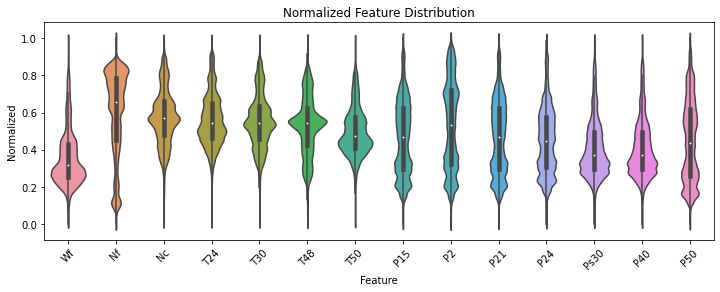

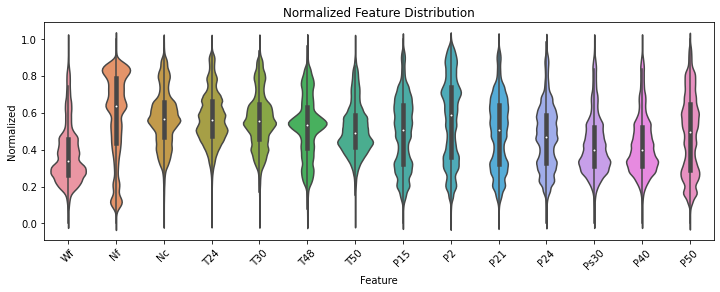

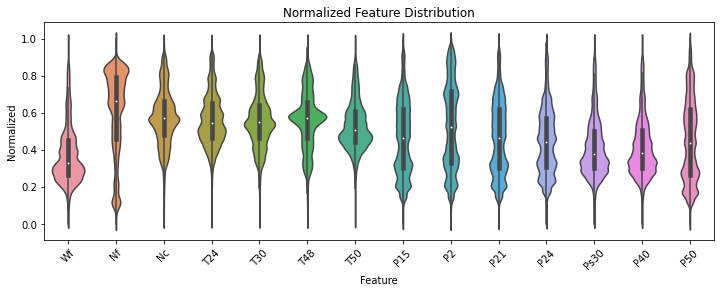

In [9]:
utils.plot_feature_distributions(df=train_df, feature_range=(0,1), figsize=(12,4))
utils.plot_feature_distributions(df=val_df, feature_range=(0,1), figsize=(12,4))
utils.plot_feature_distributions(df=test_df, feature_range=(0,1), figsize=(12,4))

### plot feature importances

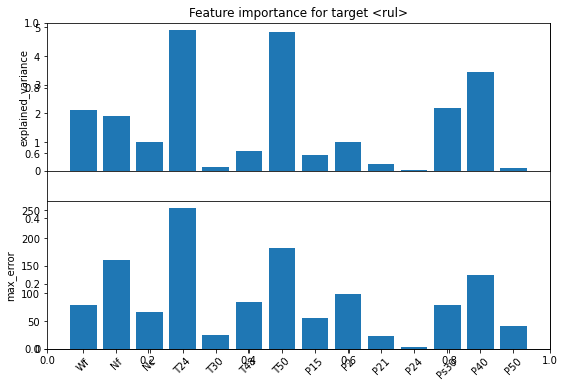

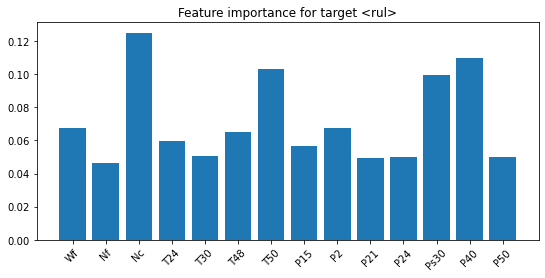

In [10]:
from xgboost import XGBRegressor
importance_model = XGBRegressor()
importance_model.fit(train_df.values, train_y)

scoring = ['explained_variance',
           'max_error']#,
           #'neg_mean_absolute_error',
           #'neg_root_mean_squared_error',
           #'r2']

utils.plot_feature_importances(model=importance_model,
                               features=train_df.values,
                               feature_labels=y_cols,
                               target=train_y,
                               target_label='rul',
                               scoring=scoring)

utils.plot_feature_importance(features=train_df.values,
                              feature_labels=y_cols,
                              target=train_y,
                              target_label='rul',
                              figsize=(9,4))

In [28]:
important_features = list(train_df.columns) #['Wf','Nc', 'T24', 'T48', 'T50', 'P2', 'Ps30', 'P40']
important_features

['Wf',
 'Nf',
 'Nc',
 'T24',
 'T30',
 'T48',
 'T50',
 'P15',
 'P2',
 'P21',
 'P24',
 'Ps30',
 'P40',
 'P50',
 'Mach',
 'alt',
 'TRA',
 'T2',
 'time']

In [22]:
train_df.head()

,hs,Fc,Wf,Nf,Nc,T24,T30,T48,T50,P15,...,P21,P24,Ps30,P40,P50,Mach,alt,TRA,T2,time
21666,1.0,3.0,0.904605,0.920894,0.942631,0.946640,0.938773,0.931891,0.939137,0.952171,...,0.952237,0.942326,0.924712,0.925356,0.968429,0.474806,0.002810,0.862534,0.954339,0.000000
21667,1.0,3.0,0.902882,0.922234,0.942841,0.949453,0.938954,0.930955,0.936062,0.952920,...,0.952986,0.943620,0.923692,0.924372,0.963266,0.492219,0.007524,0.862534,0.958234,0.001481
21668,1.0,3.0,0.899923,0.922833,0.942245,0.950850,0.938337,0.929723,0.932919,0.951769,...,0.951836,0.942972,0.921234,0.921937,0.957022,0.507606,0.012894,0.862534,0.960533,0.002963
21669,1.0,3.0,0.891046,0.920543,0.937921,0.944201,0.933820,0.926404,0.929083,0.941082,...,0.941163,0.932666,0.912462,0.913144,0.947580,0.505487,0.018888,0.862534,0.952553,0.004444
21670,1.0,3.0,0.892933,0.926190,0.940406,0.946972,0.936452,0.929263,0.929421,0.939608,...,0.939692,0.932724,0.913301,0.913957,0.942313,0.517909,0.024913,0.870620,0.952616,0.005926


## 2. temporalize the data

In [29]:
lookback = 100
horizon = 1
n_out = 1
n_features = train_df[important_features].shape[1]

X_train, y_train = utils.temporalize_data(train_df[important_features].values, train_y, lookback, horizon, n_features, n_out)
#train_pop_temp, y_pop = utils.temporalize_data(train_pop.values, train_y, lookback, horizon, len(train_pop.columns), n_out)

# X_val, y_val = utils.temporalize_data(val_df.values, val_y, lookback, horizon, n_features, n_out)
# val_pop_temp, y_pop = utils.temporalize_data(val_pop.values, val_y, lookback, horizon, n_features, n_out)

# X_test, y_test = utils.temporalize_data(test_df.values, test_y, lookback, horizon, n_features, n_out)
# test_pop_temp, y_pop = utils.temporalize_data(test_pop.values, test_y, lookback, horizon, n_features, n_out)

KeyboardInterrupt: 

# TIM check gpu memory first

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    input_shape = (lookback, n_features)
    my_tuning = tuning.Tuning(input_shape, n_out)
    bayesian_tuning = my_tuning.bayesian_search(objective='root_mean_squared_error',
                                                mode='min',
                                                max_trials=256,
                                                alpha=.00025,
                                                beta=2.75,
                                                epochs=5,
                                                executions_per_trial=3,
                                                hypermodel=my_tuning.create_lstm_hypermodel,
                                                directory='logs/ncmapss/bayesiansearch',
                                                project_name='lstm',
                                                logger=TensorBoardLogger(
                                                    metrics=['root_mean_squared_error'],
                                                             logdir='logs/ncmapss/hparams'
                                                ),
                                                X=X_train,
                                                y=y_train)

bayesian_tuning_params = bayesian_tuning.get_best_hyperparameters(num_trials=1)[0]
bayesian_tuning_model = bayesian_tuning.get_best_models()[0]
print(bayesian_tuning_params.values)
bayesian_tuning_model.summary()